In [1]:
import torch
import os
from dataset import CDEDataset
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from matplotlib import cm as c

if torch.cuda.is_available(): 
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:

no_dilation_models = []
for i in range(10):
    no_dilation_models.append(torch.load(f"Models/dilationNone/conv_{i+1}_800.pt"))
    
dilation_2_models = []
for i in range(10):
    dilation_2_models.append(torch.load(f"Models/dilation2/dil2_{i+1}_800.pt"))
    
aspp_models = []
for i in range(10):
    aspp_models.append(torch.load(f"Models/aspp/aspp_{i+1}_800.pt"))

In [3]:
root_ims = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_A/test_data/images'
root_ann = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_A/test_data/density_gt'
im_list = os.listdir(root_ims)
test_SH_A = CDEDataset(im_list,root_ims,root_ann, transform  = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train =False)

root_ims = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_B/test_data/images'
root_ann = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_B/test_data/density_gt'
im_list = os.listdir(root_ims)
test_SH_B = CDEDataset(im_list,root_ims,root_ann, transform  = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train =False)

root_ims = '../CDE_Data/UCF_CC_50/images'
root_ann = '../CDE_Data/UCF_CC_50/density_gt'
im_list = os.listdir(root_ims)
test_UCF = CDEDataset(im_list,root_ims,root_ann, transform  = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train =False)

In [4]:
test_SH_A_dataloader = DataLoader(test_SH_A, batch_size=1, shuffle=True)
test_SH_B_dataloader = DataLoader(test_SH_B, batch_size=1, shuffle=True)
test_UCF_dataloader = DataLoader(test_UCF, batch_size=1, shuffle=True)

test_dataloaders = [test_SH_A_dataloader, test_SH_B_dataloader, test_UCF_dataloader]

In [5]:
def evaluate(model,dataloaders):

    maes = []
    mses = []
    for loader in dataloaders:
        losses =[]

        model.eval()
        with torch.no_grad():    
            for i, data in enumerate(loader, 0):
                # evaluate the model on the test set
                inputs, labels, true_count = data


                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                pred_count = np.sum(outputs[0][0].cpu().detach().numpy())
                true_count = true_count.cpu().detach().numpy()

                losses.append(pred_count - true_count)

                #print(i, end = " ")
        mae = np.mean(np.abs(losses))
        mse = np.sqrt(np.mean(np.square(losses)))
        maes.append(mae)
        mses.append(mse)
        #print('.', end = " ")
    print('.', end = " ")
    return maes, mses
        

In [6]:
%%time
no_dil_maes = []
no_dil_mses = []

for model in no_dilation_models:
    maes, mses = evaluate(model, test_dataloaders)
    no_dil_maes.append(maes)
    no_dil_mses.append(mses)
    
no_dil_maes = np.array(no_dil_maes)
no_dil_mses = np.array(no_dil_mses)
    
dil_2_maes = []
dil_2_mses = []

for model in dilation_2_models:
    maes, mses = evaluate(model, test_dataloaders)
    dil_2_maes.append(maes)
    dil_2_mses.append(mses)

dil_2_maes = np.array(dil_2_maes)
dil_2_mses = np.array(dil_2_mses)
    
aspp_maes = []
aspp_mses = []

for model in aspp_models:
    maes, mses = evaluate(model, test_dataloaders)
    aspp_maes.append(maes)
    aspp_mses.append(mses)
    
aspp_maes = np.array(aspp_maes)
aspp_mses = np.array(aspp_mses)   

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Wall time: 48min 14s


In [7]:
no_dil_mae_mean = np.mean(no_dil_maes, axis = 0)
dil_2_mae_mean = np.mean(dil_2_maes, axis = 0)
aspp_mae_mean = np.mean(aspp_maes, axis = 0)

print("Mean MAE:")
print("Baseline", "SHT_A: ", no_dil_mae_mean[0],"SHT_B: ", no_dil_mae_mean[1] ,"UCF: ", no_dil_mae_mean[2])
print("Dilated ", "SHT_A: ", dil_2_mae_mean[0],"SHT_B: ", dil_2_mae_mean[1] ,"UCF: ", dil_2_mae_mean[2])
print("ASPP", "SHT_A: ", aspp_mae_mean[0],"SHT_B: ", aspp_mae_mean[1] ,"UCF: ", aspp_mae_mean[2])
print()

no_dil_mse_mean = np.mean(no_dil_mses, axis = 0)
dil_2_mse_mean = np.mean(dil_2_mses, axis = 0)
aspp_mse_mean = np.mean(aspp_mses, axis = 0)

print("Mean MSE:")
print("Baseline", "SHT_A: ", no_dil_mse_mean[0],"SHT_B: ", no_dil_mse_mean[1] ,"UCF: ", no_dil_mse_mean[2])
print("Dilated ", "SHT_A: ", dil_2_mse_mean[0],"SHT_B: ", dil_2_mse_mean[1] ,"UCF: ", dil_2_mse_mean[2])
print("ASPP", "SHT_A: ", aspp_mse_mean[0],"SHT_B: ", aspp_mse_mean[1] ,"UCF: ", aspp_mse_mean[2])
#print()




Mean MAE:
Baseline SHT_A:  91.15835941885855 SHT_B:  29.092100143357175 UCF:  511.0183964195251
Dilated  SHT_A:  89.42049200037023 SHT_B:  24.01543555899134 UCF:  443.42315505218505
ASPP SHT_A:  81.52560221808298 SHT_B:  25.377195494537112 UCF:  426.6602043662071

Mean MSE:
Baseline SHT_A:  149.59387384038715 SHT_B:  40.72042062656437 UCF:  751.5177443943765
Dilated  SHT_A:  130.92293504334924 SHT_B:  36.23799277466889 UCF:  654.2110074844624
ASPP SHT_A:  124.88744073647986 SHT_B:  32.779157310018476 UCF:  628.6180010116879


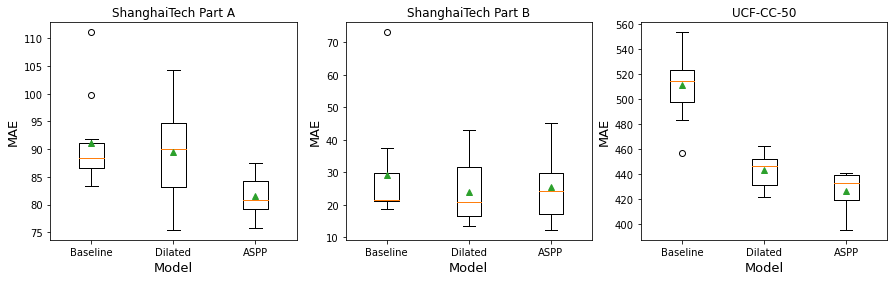

In [24]:
#MAE
fig, axs = plt.subplots(1, 3, figsize = (15,4))

sht_a_maes = [no_dil_maes[:,0], dil_2_maes[:,0], aspp_maes[:,0]]
 
bp = axs[0].boxplot(sht_a_maes, showmeans=True)

axs[0].set_xticklabels(['Baseline', 'Dilated','ASPP'])
axs[0].set_ylabel("MAE", fontsize = 13)
axs[0].set_xlabel("Model", fontsize = 13)
axs[0].title.set_text('ShanghaiTech Part A')


sht_b_maes = [no_dil_maes[:,1], dil_2_maes[:,1], aspp_maes[:,1]]

bp = axs[1].boxplot(sht_b_maes, showmeans=True)

axs[1].set_xticklabels(['Baseline', 'Dilated','ASPP'])
axs[1].set_ylabel("MAE", fontsize = 13)
axs[1].set_xlabel("Model", fontsize = 13)
axs[1].title.set_text('ShanghaiTech Part B')


ucf_maes = [no_dil_maes[:,2], dil_2_maes[:,2], aspp_maes[:,2]]

bp = axs[2].boxplot(ucf_maes, showmeans=True)

axs[2].set_xticklabels(['Baseline', 'Dilated', 'ASPP'])
axs[2].set_ylabel("MAE", fontsize = 13)
axs[2].set_xlabel("Model", fontsize = 13)
axs[2].title.set_text('UCF-CC-50')
plt.savefig('MAE.pdf', bbox_inches='tight')
plt.show()


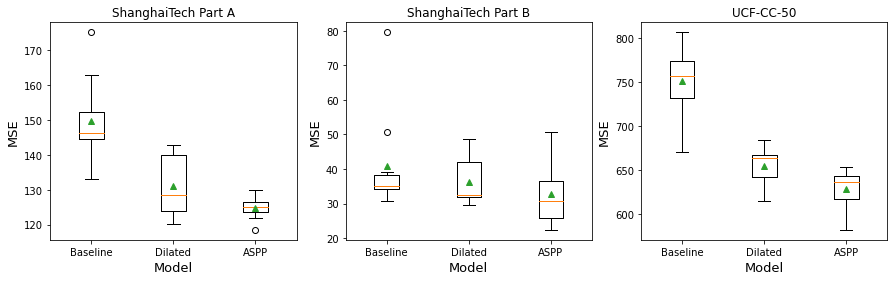

In [23]:
#MSE
fig, axs = plt.subplots(1, 3, figsize = (15,4))

sht_a_mses = [no_dil_mses[:,0], dil_2_mses[:,0], aspp_mses[:,0]]
 
bp = axs[0].boxplot(sht_a_mses, showmeans=True)

axs[0].set_xticklabels(['Baseline', 'Dilated','ASPP'])
axs[0].set_ylabel("MSE", fontsize = 13)
axs[0].set_xlabel("Model", fontsize = 13)
axs[0].title.set_text('ShanghaiTech Part A')


sht_b_mses = [no_dil_mses[:,1], dil_2_mses[:,1], aspp_mses[:,1]]

bp = axs[1].boxplot(sht_b_mses, showmeans=True)

axs[1].set_xticklabels(['Baseline', 'Dilated','ASPP'])
axs[1].set_ylabel("MSE", fontsize = 13)
axs[1].set_xlabel("Model", fontsize = 13)
axs[1].title.set_text('ShanghaiTech Part B')


ucf_mses = [no_dil_mses[:,2], dil_2_mses[:,2], aspp_mses[:,2]]

bp = axs[2].boxplot(ucf_mses, showmeans=True)

axs[2].set_xticklabels(['Baseline', 'Dilated', 'ASPP'])
axs[2].set_ylabel("MSE", fontsize = 13)
axs[2].set_xlabel("Model", fontsize = 13)
axs[2].title.set_text('UCF-CC-50')

plt.savefig('MSE.pdf', bbox_inches='tight')
plt.show()


In [10]:
datasets = ["SHT Part A", "SHT Part B", "UCF-CC-50"]
print('statistical significance for MAE vals:')
for i in range (3):
    ds = datasets[i]
    
    stat, p = mannwhitneyu(no_dil_maes[:,i], dil_2_maes[:,i])
    print(f'Base and Dilated on {datasets[i]}: p = ',p)
    stat, p = mannwhitneyu(no_dil_maes[:,i], aspp_maes[:,i])
    print(f'Base and ASPP on {datasets[i]}: p = ',p)
    stat, p = mannwhitneyu(dil_2_maes[:,i], aspp_maes[:,i])
    print(f'Dilated and ASPP on {datasets[i]}: p = ',p)
    print()

statistical significance for MAE vals:
Base and Dilated on SHT Part A: p =  0.42505336956926293
Base and ASPP on SHT Part A: p =  0.0005039881201883722
Dilated and ASPP on SHT Part A: p =  0.032011050641513446

Base and Dilated on SHT Part B: p =  0.19233653136775436
Base and ASPP on SHT Part B: p =  0.26026144163788634
Dilated and ASPP on SHT Part B: p =  0.45486094457277765

Base and Dilated on UCF-CC-50: p =  0.00016491926038899677
Base and ASPP on UCF-CC-50: p =  9.133589555477501e-05
Dilated and ASPP on UCF-CC-50: p =  0.008628728041559883



In [25]:
datasets = ["SHT Part A", "SHT Part B", "UCF-CC-50"]
print('statistical significance for MSE vals:')
for i in range (3):
    ds = datasets[i]
    
    stat, p = mannwhitneyu(no_dil_mses[:,i], dil_2_mses[:,i])
    print(f'Base and Dilated on {datasets[i]}: p = ',p)
    stat, p = mannwhitneyu(no_dil_mses[:,i], aspp_mses[:,i])
    print(f'Base and ASPP on {datasets[i]}: p = ',p)
    stat, p = mannwhitneyu(dil_2_mses[:,i], aspp_mses[:,i])
    print(f'Dilated and ASPP on {datasets[i]}: p = ',p)
    print()

statistical significance for MSE vals:
Base and Dilated on SHT Part A: p =  0.0006574723348566069
Base and ASPP on SHT Part A: p =  9.133589555477501e-05
Dilated and ASPP on SHT Part A: p =  0.06061225150645831

Base and Dilated on SHT Part B: p =  0.15374472830934066
Base and ASPP on SHT Part B: p =  0.09293836618293788
Dilated and ASPP on SHT Part B: p =  0.15374472830934066

Base and Dilated on UCF-CC-50: p =  0.00012306406395261486
Base and ASPP on UCF-CC-50: p =  9.133589555477501e-05
Dilated and ASPP on UCF-CC-50: p =  0.01056696406458055



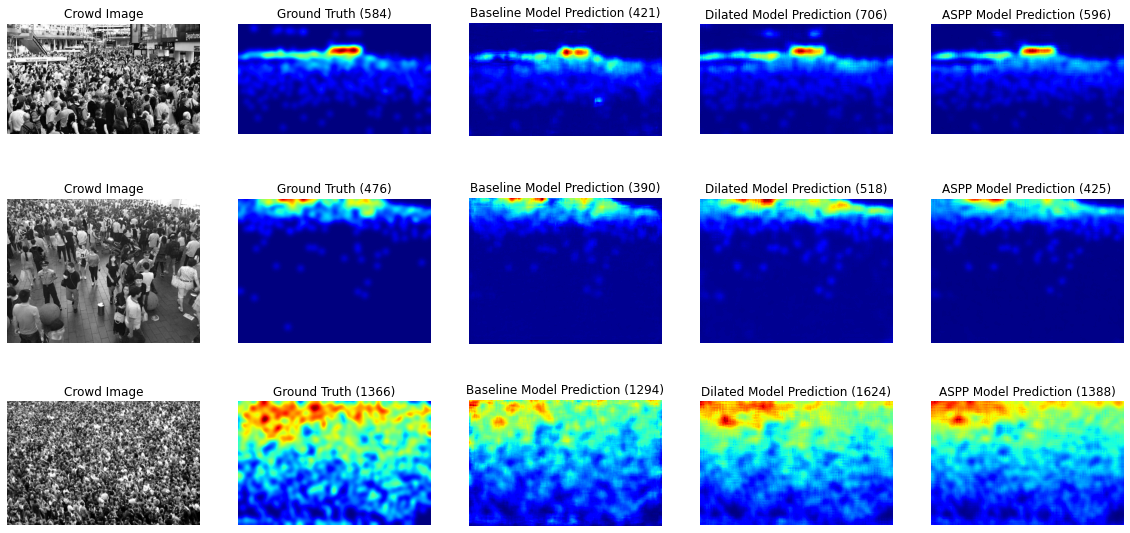

In [33]:
import gc

fig, axs = plt.subplots(3, 5, figsize=(20,10))#43
test_examples = [test_SH_A[34], test_SH_B[9], test_UCF[40]]
count =0
for x in test_examples:

    axs[count][0].imshow(x[0][0].detach().numpy(), cmap = 'gray')
    axs[count][0].axis('off')
    axs[count][0].title.set_text('Crowd Image')

    axs[count][1].imshow(x[1][0].detach().numpy(), cmap = c.jet)
    axs[count][1].axis('off')
    axs[count][1].title.set_text(f'Ground Truth ({x[2]})')

    
    im = x[0].unsqueeze(0).to(device)
    
    bas = no_dilation_models[0](im)
    axs[count][2].imshow(bas[0][0].cpu().detach().numpy(), cmap = c.jet)
    axs[count][2].axis('off')
    crowd_count = int(np.around(np.sum(bas[0][0].cpu().detach().numpy())))
    axs[count][2].title.set_text(f'Baseline Model Prediction ({crowd_count})')

    del bas
    
    di = dilation_2_models[0](im)
    axs[count][3].imshow(di[0][0].cpu().detach().numpy(), cmap = c.jet)
    axs[count][3].axis('off')
    crowd_count = int(np.around(np.sum(di[0][0].cpu().detach().numpy())))
    axs[count][3].title.set_text(f'Dilated Model Prediction ({crowd_count})')
    del di
    
    asp = aspp_models[0](im)
    axs[count][4].imshow(asp[0][0].cpu().detach().numpy(), cmap = c.jet)
    axs[count][4].axis('off')
    crowd_count = int(np.around(np.sum(asp[0][0].cpu().detach().numpy())))
    axs[count][4].title.set_text(f'ASPP Model Prediction ({crowd_count})')
    
    del asp
    count+=1
    
    torch.cuda.empty_cache()

    del im
    gc.collect()
    

plt.savefig('maps.pdf', bbox_inches='tight')
plt.show()

inference time: 0.048949480056762695
actual:  289
predicted:  252.84067


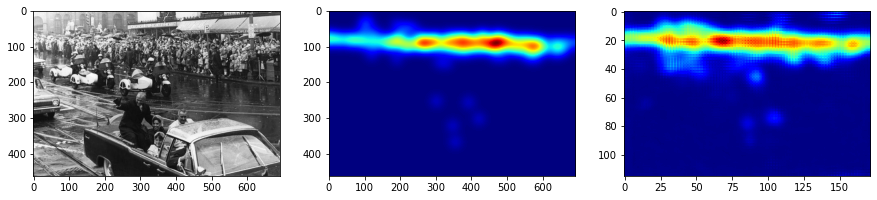

In [18]:
ex = test_SH_A[9]
im = ex[0].unsqueeze(0).to(device)
im.shape

start = time.time()
a = aspp_models[0](im)

print("inference time:", time.time() - start)
print("actual: ",ex[2])
print("predicted: ",np.sum(a[0][0].cpu().detach().numpy()))

fig, axs = plt.subplots(1, 3, figsize=(15,20))
axs[0].imshow(ex[0][0].detach().numpy(), cmap = 'gray')
axs[1].imshow(ex[1][0].detach().numpy(), cmap = c.jet)
axs[2].imshow(a[0][0].cpu().detach().numpy(), cmap = c.jet)
plt.show()

actual:  431


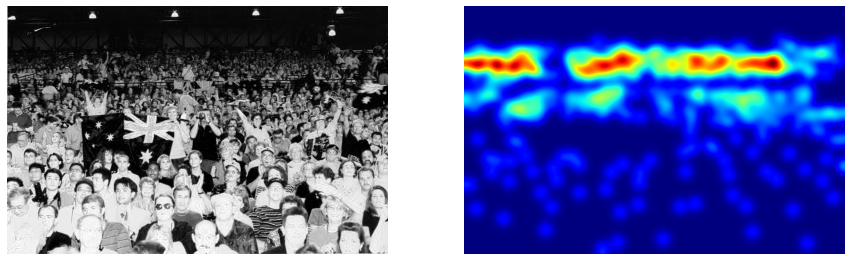

In [34]:
ex = test_SH_A[5]

print("actual: ",ex[2])

fig, axs = plt.subplots(1, 2, figsize=(15,20))
axs[0].imshow(ex[0][0].detach().numpy(), cmap = 'gray')
axs[1].imshow(ex[1][0].detach().numpy(), cmap = c.jet)
axs[0].axis('off')
axs[1].axis('off')

plt.savefig('Example.pdf', bbox_inches = 'tight')
plt.show()

In [6]:
plt.imsave('ex_im.png',ex[0][0].detach().numpy(), cmap = 'gray')

In [8]:
plt.imsave('ex_gt.png',a[0][0].cpu().detach().numpy(), cmap = c.jet)

In [9]:
aspp_models[0]

ASPPNet(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
  (aspp1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1